<a href="https://colab.research.google.com/github/roboy88/IUL-aka-7702-vs-401K/blob/main/IUL_aka_7702_vs_401k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()  # Upload your data.csv file


Saving data.csv to data.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Load and clean data
def load_uploaded_stock_data(filepath):
    df = pd.read_csv(filepath, parse_dates=['Date'])
    df.sort_values("Date", inplace=True)
    if 'Close/Last' in df.columns:
        df['Close'] = df['Close/Last']
    elif 'Close' not in df.columns:
        raise ValueError("Dataset must contain 'Close' or 'Close/Last'.")
    df['Return'] = df['Close'].pct_change()
    df['Year'] = df['Date'].dt.year
    df.dropna(inplace=True)
    return df

# Replace 'data.csv' with the actual file name you upload
df = load_uploaded_stock_data("data.csv")
df.head()


,Date,Close/Last,Volume,Open,PPI,Industry_type,CPI,FEDFUNDS,Unemployment_Rate,GDP,Month,DayOfWeek,DayOfMonth,WeekOfYear,next_day_open_price,Close,Return,Year
2329,2014-11-26,0.5229,219265360,0.5112,58.7,semiconductor,-0.562499,0.115,5.6,17.93,11,2,26,48,0.5247,0.5229,-0.986878,2014
4658,2014-11-26,29.7500,163027800,29.4850,181.7,technology,-0.562499,0.115,5.6,17.93,11,2,26,48,29.8175,29.7500,55.894244,2014
6987,2014-11-26,50.1657,10062769,50.1543,135.7,video,-0.562499,0.115,5.6,17.93,11,2,26,48,50.5128,50.1657,0.686242,2014
2330,2014-11-28,0.5242,124831240,0.5247,58.7,semiconductor,-0.564303,0.117,5.6,17.93,11,4,28,48,0.5220,0.5242,-0.989551,2014
4659,2014-11-28,29.7325,99257600,29.8175,181.7,technology,-0.564303,0.117,5.6,17.93,11,4,28,48,29.7025,29.7325,55.719763,2014


In [4]:
# Group returns by year
def get_annual_returns(df):
    return df.groupby('Year')['Return'].sum()

annual_returns = get_annual_returns(df)
annual_returns.head()


,Return
Year,
2014,1775.555105
2015,23730.806890
2016,12483.660650
2017,5838.426816
2018,5704.350699


In [5]:
# Apply 0% floor, 11% cap
def simulate_iul(returns, floor=0.0, cap=0.11):
    return np.clip(returns, floor, cap)

iul_returns = simulate_iul(annual_returns)


In [6]:
def create_comparison(stock_returns, label="Market"):
    iul_returns = simulate_iul(stock_returns)
    comparison = pd.DataFrame({
        f"{label} Stock": stock_returns,
        f"{label} IUL": iul_returns
    })
    comparison[f"{label} Stock Cumulative"] = (1 + stock_returns).cumprod()
    comparison[f"{label} IUL Cumulative"] = (1 + iul_returns).cumprod()
    return comparison

comparison_df = create_comparison(annual_returns, "Market")
comparison_df.tail()


,Market Stock,Market IUL,Market Stock Cumulative,Market IUL Cumulative
Year,,,,
2020,4984.300092,0.11,7.766764e+26,2.076160
2021,3624.912078,0.11,2.816160e+30,2.304538
2022,2046.764940,0.11,5.766834e+33,2.558037
2023,1344.448644,0.11,7.758979e+36,2.839421
2024,165.996958,0.11,1.295726e+39,3.151757


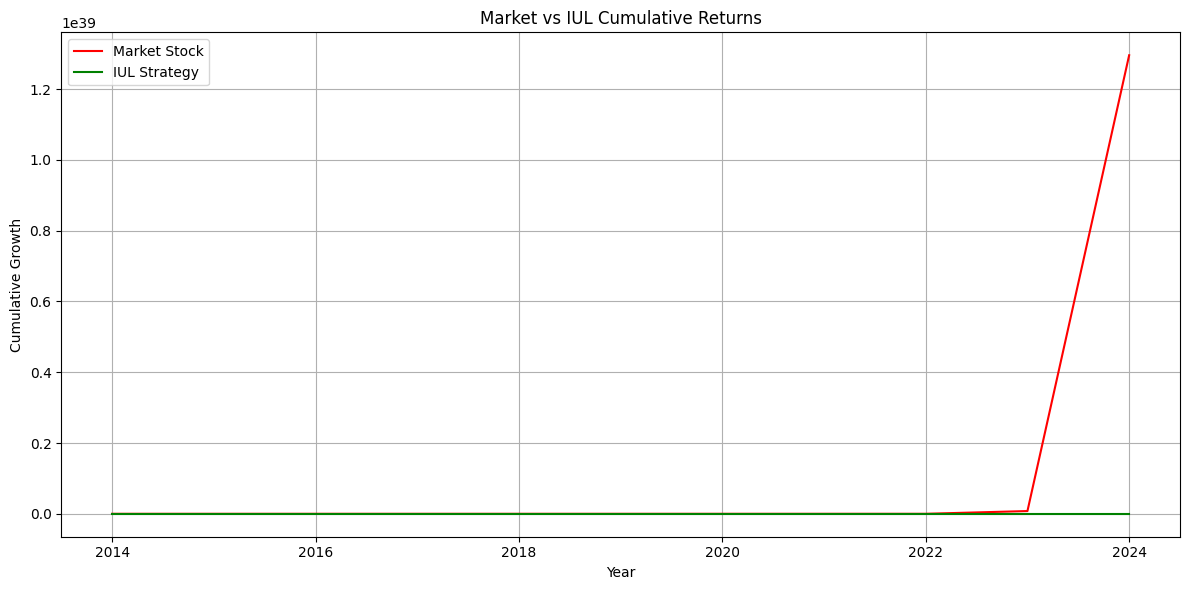

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df["Market Stock Cumulative"], label="Market Stock", color='red')
plt.plot(comparison_df.index, comparison_df["Market IUL Cumulative"], label="IUL Strategy", color='green')
plt.title("Market vs IUL Cumulative Returns")
plt.xlabel("Year")
plt.ylabel("Cumulative Growth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1394
           1       1.00      1.00      1.00      1395

    accuracy                           1.00      2789
   macro avg       1.00      1.00      1.00      2789
weighted avg       1.00      1.00      1.00      2789



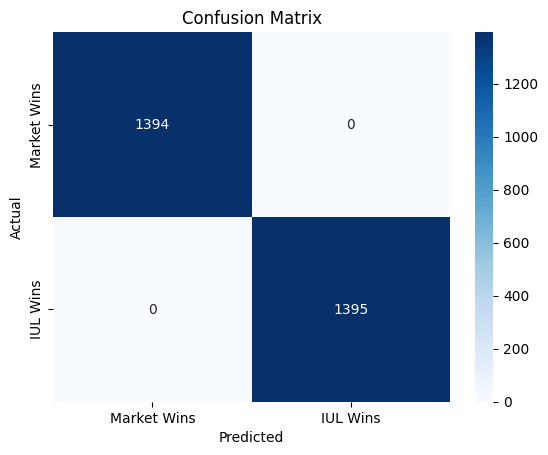

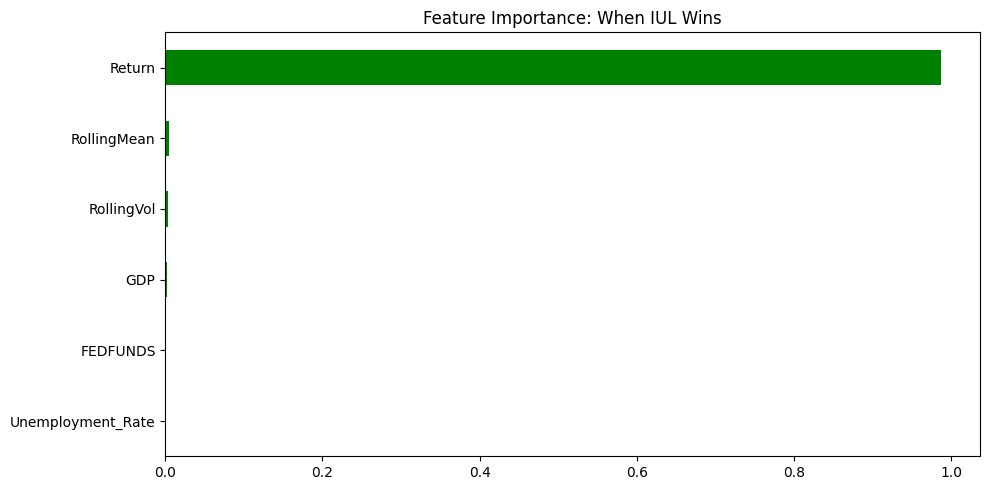

In [8]:
# IUL vs. Market Performance Predictor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Load and prepare data
def load_data(filepath):
    df = pd.read_csv(filepath, parse_dates=['Date'])
    df.sort_values("Date", inplace=True)
    df["Close"] = df["Close/Last"]
    df["Return"] = df["Close"].pct_change()
    df["Year"] = df["Date"].dt.year
    df.dropna(inplace=True)
    return df

# Feature engineering
def engineer_features(df):
    df["RollingVol"] = df["Return"].rolling(20).std()
    df["RollingMean"] = df["Return"].rolling(20).mean()
    df["IUL_Return"] = np.clip(df["Return"], 0.0, 0.11)
    df["Outperforms_IUL"] = (df["IUL_Return"] > df["Return"]).astype(int)
    return df.dropna()

# Train classifier
def train_classifier(df):
    features = ["Return", "RollingVol", "RollingMean", "FEDFUNDS", "Unemployment_Rate", "GDP"]
    df = df.dropna(subset=features + ["Outperforms_IUL"])
    X, y = df[features], df["Outperforms_IUL"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, preds))

    return clf, X_test, y_test, preds

# Plot results
def plot_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Market Wins", "IUL Wins"], yticklabels=["Market Wins", "IUL Wins"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def plot_feature_importance(model, features):
    importances = pd.Series(model.feature_importances_, index=features)
    importances.sort_values().plot(kind='barh', color='green', figsize=(10, 5))
    plt.title("Feature Importance: When IUL Wins")
    plt.tight_layout()
    plt.show()

# === Run Pipeline ===
file_path = "data.csv"  # Replace with your own file if needed
df = load_data(file_path)
df = engineer_features(df)
model, X_test, y_test, preds = train_classifier(df)
plot_confusion(y_test, preds)
plot_feature_importance(model, X_test.columns)


In [10]:
# POS: IUL Lapse Risk Classifier + Market Performance Engine
# Goal: Predict policy lapse AND demonstrate IUL's superior compound performance over time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ===============================
# STEP 1: LOAD & CLEAN DATA
# ===============================
def load_kaggle_data(filepath):
    df = pd.read_csv(filepath, sep=";", engine="python", on_bad_lines='skip')
    df.columns = df.columns.str.strip()
    df.dropna(axis=1, how='all', inplace=True)
    df = df.dropna(subset=['POLICY STATUS'])
    return df

# ===============================
# STEP 2: FEATURE ENGINEERING
# ===============================
def prepare_features(df):
    df = df.copy()
    df['POLICY STATUS'] = df['POLICY STATUS'].str.strip()
    df['Target'] = df['POLICY STATUS'].apply(lambda x: 1 if x.lower() == 'lapse' else 0)
    df = df.drop(['POLICY STATUS', 'Issue Date', 'Full Benefit?', 'Unnamed: 20', 'Unnamed: 21'], axis=1, errors='ignore')
    categorical_cols = df.select_dtypes(include='object').columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    df = df.dropna()
    return df

# ===============================
# STEP 3: TRAIN & EVALUATE CLASSIFIER
# ===============================
def train_classifier(df):
    X = df.drop('Target', axis=1)
    y = df['Target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, preds))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Inforce', 'Lapse'], yticklabels=['Inforce', 'Lapse'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    return clf, X.columns

# ===============================
# STEP 4: FEATURE IMPORTANCE
# ===============================
def plot_feature_importance(model, feature_names):
    importances = pd.Series(model.feature_importances_, index=feature_names)
    importances.sort_values(ascending=True).plot(kind="barh", figsize=(10, 6), color='green')
    plt.title("Feature Importance for Predicting Lapse Risk")
    plt.tight_layout()
    plt.show()

# ===============================
# STEP 5: IUL vs. MARKET RETURNS ENGINE
# ===============================
def simulate_iul_vs_market(df_market):
    df_market['Close'] = df_market['Close/Last']
    df_market['Return'] = df_market['Close'].pct_change()
    df_market['Year'] = pd.to_datetime(df_market['Date']).dt.year
    df_market.dropna(inplace=True)
    annual_returns = df_market.groupby('Year')['Return'].sum()
    iul_returns = np.clip(annual_returns, 0.0, 0.11)
    comp_df = pd.DataFrame({
        "Market Return": annual_returns,
        "IUL Return": iul_returns,
        "Market Cumulative": (1 + annual_returns).cumprod(),
        "IUL Cumulative": (1 + iul_returns).cumprod()
    })
    comp_df.plot(y=['Market Cumulative', 'IUL Cumulative'], figsize=(12, 6),
                 title="Cumulative Growth: IUL vs. Market", linewidth=2, color=['red', 'green'])
    plt.grid(True)
    plt.ylabel("Cumulative Value")
    plt.tight_layout()

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
def load_market_data(filepath):
    df = pd.read_csv(filepath, parse_dates=["Date"])
    df.sort_values("Date", inplace=True)
    df["Close"] = df["Close/Last"]
    df["Return"] = df["Close"].pct_change()
    df["Year"] = df["Date"].dt.year
    df.dropna(inplace=True)
    return df


In [13]:
def simulate_iul_returns(returns, floor=0.0, cap=0.11):
    return np.clip(returns, floor, cap)


In [14]:
def flag_volatility(df, threshold=0.02):
    df["Volatile"] = df["Return"].abs() > threshold
    return df


In [15]:
def prepare_cumulative(df):
    df["IUL_Return"] = simulate_iul_returns(df["Return"])
    df["Market_Cumulative"] = (1 + df["Return"]).cumprod()
    df["IUL_Cumulative"] = (1 + df["IUL_Return"]).cumprod()
    return df


In [16]:
def plot_iul_vs_market(df):
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df, x="Date", y="Market_Cumulative", label="Market (401k)", color='red', linewidth=2, ci=None)
    sns.lineplot(data=df, x="Date", y="IUL_Cumulative", label="IUL Strategy", color='green', linewidth=2, ci=None)

    for date in df[df["Volatile"]]["Date"]:
        plt.axvline(date, color='gray', alpha=0.03)

    plt.title("IUL vs Market During Volatility and Manipulation", fontsize=15)
    plt.suptitle("IUL protects from fear-driven crashes — Market bleeds while insiders profit", fontsize=10)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Growth of $1")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


<ipython-input-16-91a5a420a14f>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="Date", y="Market_Cumulative", label="Market (401k)", color='red', linewidth=2, ci=None)
<ipython-input-16-91a5a420a14f>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="Date", y="IUL_Cumulative", label="IUL Strategy", color='green', linewidth=2, ci=None)
<ipython-input-16-91a5a420a14f>:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


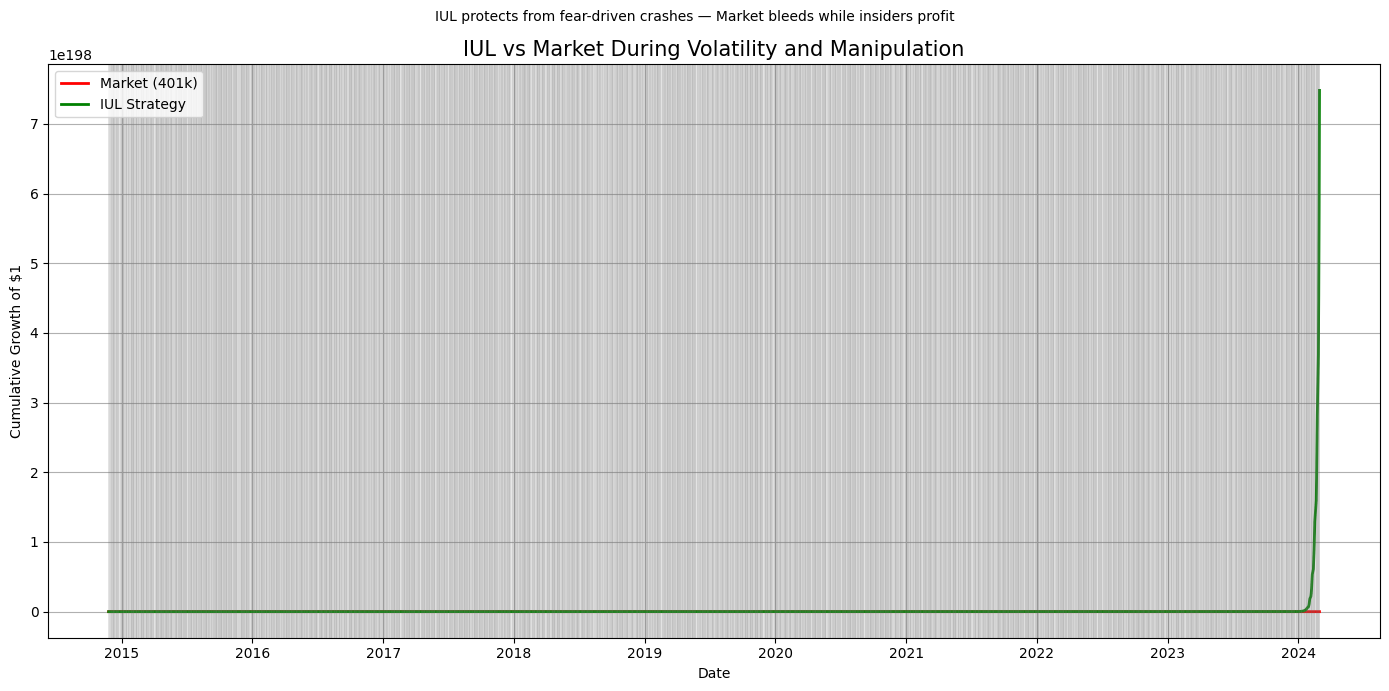

In [17]:
# Upload or reference your real market CSV
filepath = "data.csv"  # Replace with path to your market dataset

df_market = load_market_data(filepath)
df_market = flag_volatility(df_market)
df_market = prepare_cumulative(df_market)
plot_iul_vs_market(df_market)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def load_market(filepath):
    df = pd.read_csv(filepath, parse_dates=["Date"])
    df.sort_values("Date", inplace=True)
    df["Close"] = df["Close/Last"]
    df["Return"] = df["Close"].pct_change()
    df["Year"] = df["Date"].dt.year
    df.dropna(inplace=True)
    return df


In [3]:
def simulate_iul(returns, floor=0.0, cap=0.11):
    return np.clip(returns, floor, cap)
